In [132]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [133]:
transacs = pd.read_csv('../../__DATA__/creditcard.csv')

In [4]:
transacs.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


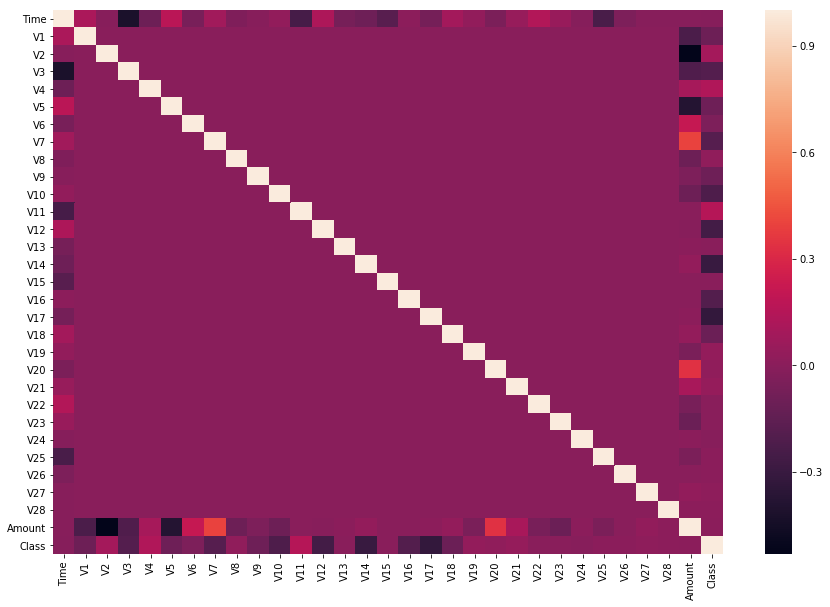

In [8]:
corrmat = transacs.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat)

AttributeError: Unknown property style

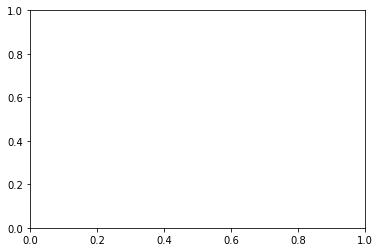

In [161]:
frauds = transacs.loc[transacs['Class']==1]
plt.plot()

### Overall Strategy:
Keep many models in mind: SVC, Decision Trees, Regressions, Boosting Methods. The modeling methods that probability would not work are the Naive Bayes classifier and KNN classifiers, because the data here is very complex and interconnected - these said models rely ignore dependence between features and rely too heavily on similarity.

SVC and Lasso/Ridge Logistic Regression are great starting points, then bagging and boosting methods next. Each modeling method will be iterated with over/undersampling of the minority or majority to refine the sensitvity (detection of False Negative).

We also need to make sure to get rid of the outliers if any. PCA, while sensitive to outliers, does not necessarily rid of them entirely.

## Data Cleaning and Preparation

In [63]:
from scipy import stats as sp

In [134]:
transacs['Amount'].index.where(transacs.Amount == 0).dropna()

Float64Index([   383.0,    514.0,    534.0,    541.0,    575.0,    936.0,
                1059.0,   1072.0,   1170.0,   1526.0,
              ...
              281731.0, 281963.0, 282500.0, 282596.0, 282904.0, 283719.0,
              283782.0, 283949.0, 284085.0, 284770.0],
             dtype='float64', length=1825)

In [152]:
# Creating DF1, where
index = transacs['Amount'].index.where(transacs.Amount > 0).dropna()
df1 = transacs.iloc[index,:]
#df1.skew() <= -2
transacs.skew() #.columns.where(df1.skew() <= -2).dropna()

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

In [80]:
transacs.columns.where(transacs.skew() <= -2)

Index([  nan,  'V1',  'V2',  'V3',   nan,  'V5',   nan,   nan,  'V8',   nan,
         nan,   nan, 'V12',   nan,   nan,   nan,   nan, 'V17',   nan,   nan,
       'V20',   nan,   nan, 'V23',   nan,   nan,   nan,   nan,   nan,   nan,
         nan],
      dtype='object')

In [153]:
cols_root = transacs.columns.where(transacs.skew() <= -2).dropna()
cols_log = transacs.columns.where(transacs.skew() >= 2).dropna()
cols_log = cols_log.drop('Class')

In [154]:
for i in transacs.columns.drop(['Time','Class']):
    if min(transacs[i]) <= 0:
        df1[i] = transacs[i] + abs(min(transacs[i])) + 1

In [155]:
for i in cols_root:
    df1[i] = df1[i]**(1/2)
for i in cols_log:
    df1[i] = np.log(df1[i])

In [128]:
df1.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,7.486501,8.581547,7.201523,8.061326,10.696027,27.622894,3.802138,8.620639,14.797853,...,3.578285,12.210981,6.759975,3.903555,11.423936,3.415436,23.699238,2.797832,5.014760,0
1,0.0,7.655022,8.601272,7.035060,7.131325,10.714631,27.078145,3.795005,8.619850,14.178641,...,3.572475,11.294472,6.775620,3.496780,11.462567,3.730445,23.556696,2.800010,1.305626,0
2,1.0,7.486598,8.507383,7.148342,7.062951,10.688316,28.961005,3.814382,8.629275,12.919412,...,3.585694,12.704823,6.834994,3.147346,10.967755,3.465454,23.510327,2.795471,5.939276,0
3,1.0,7.512738,8.574993,7.149726,5.819880,10.711349,28.407709,3.802093,8.636791,13.047042,...,3.575769,11.938417,6.754067,2.661052,11.942773,3.382622,23.628402,2.802848,4.824306,0
4,2.0,7.499952,8.636751,7.132623,7.086205,10.692807,27.256427,3.809994,8.599197,15.251806,...,3.578533,12.731422,6.757979,3.977894,11.089387,4.106843,23.785102,2.812124,4.262539,0


In [61]:
df1.skew()

Time      -0.035448
V1        -1.392947
V2         0.942889
V3        -0.091308
V4         0.662613
V5         1.011695
V6         1.848706
V7        -1.219334
V8         1.477333
V9         0.566120
V10        1.257844
V11        0.349984
V12        0.019785
V13        0.064628
V14       -1.932348
V15       -0.308001
V16       -1.090530
V17        0.714944
V18       -0.257482
V19        0.113700
V20        2.074979
V21       -0.811227
V22       -0.218699
V23        2.730036
V24       -0.551418
V25       -0.416507
V26        0.572951
V27       -1.195767
V28       -0.650334
Amount    -0.230509
Class     24.608363
dtype: float64

In [204]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import random

In [45]:
transacs['Amount'].where(transacs.Amount == 0).count()
#plt.hist(transacs['Amount'])

1825

In [164]:
#Resampling to Control Number of non-fraud transaction in training set
index_pos = df1['Class'].index.where(df1.Class == 1).dropna().tolist()
index_neg = df1['Class'].index.where(df1.Class == 0).dropna().tolist()
index_pos = [ int(x) for x in index_pos ]
index_neg = [ int(x) for x in index_neg ]
random.sample(index_neg, len(index_pos))
index_neg = random.sample(index_neg, int(len(index_pos)))
index_pos.extend(index_neg)
index_pos.sort()
modeldf = df1.loc[index_pos]

In [165]:
X = modeldf.iloc[:,:30]
Y = modeldf['Class']

clf = LogisticRegression(solver='sag', penalty='none')
clf.fit(X,Y)
cross_val_score(clf, X, Y, cv=10)

array([0.4787234, 0.5      , 0.5      , 0.5      , 0.5      , 0.5      ,
       0.5      , 0.5      , 0.5      , 0.5      ])

### Iteration: Logistic Regression, Only 'Amount' Transformed

In [200]:
#creating new population df with untransformed data
df2 = transacs
df2['Amount'] = df2['Amount'] + abs(min(transacs['Amount'])) + 1
df2['Amount'] = np.log(df2['Amount'])

#Resampling to Control Number of non-fraud transaction in training set
index_pos = df2['Class'].index.where(df2.Class == 1).dropna().tolist()
index_neg = df2['Class'].index.where(df2.Class == 0).dropna().tolist()
index_pos = [ int(x) for x in index_pos ]
index_neg = [ int(x) for x in index_neg ]
random.sample(index_neg, len(index_pos))
index_neg = random.sample(index_neg, int(len(index_neg)*0.1))
index_pos.extend(index_neg)
index_pos.sort()
modeldf = df2.loc[index_pos]

In [168]:
X = modeldf.iloc[:,:30]
Y = modeldf['Class']

clf = LogisticRegression(solver='sag', penalty='none')
clf.fit(X,Y)
cross_val_score(clf, X, Y, cv=10)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

### Iteration: Random Forest Classifier, Only 'Amount' Transformed

In [182]:
X = modeldf.iloc[:,:30]
Y = modeldf['Class']

clf = RandomForestClassifier(n_estimators = 500, criterion='entropy',
                             max_depth = 5)
clf.fit(X,Y)
cross_val_score(clf, X, Y, cv=10)

array([0.97      , 0.96      , 1.        , 0.87755102, 0.8877551 ,
       0.92857143, 0.95918367, 0.91836735, 0.93877551, 0.89795918])

In [193]:
Xtest = df2.iloc[:,:30]
preds = clf.predict(Xtest)
pred_counts = (preds == df2['Class']).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
conmax = confusion_matrix(df2['Class'],preds)
print('\nType 2 Error / Unnoticed Fraud: {}'.format(conmax[1,0]/conmax[1].sum()))
print('\nType 1 Error / Flagged Non-Fraud: {}'.format(conmax[0,1]/conmax[0].sum()))


Overall Accuracy: 0.9862784271454003
3908 total misclassified out of 284807.

Type 2 Error / Unnoticed Fraud: 0.08943089430894309

Type 1 Error / Flagged Non-Fraud: 0.01359055976645622


### Iteration: Gradient Boosting Classifier, 'Amount' Transformed

In [201]:
X = modeldf.iloc[:,:30]
Y = modeldf['Class']

clf = GradientBoostingClassifier(n_estimators = 200, criterion='friedman_mse',
                             max_depth = 3)
clf.fit(X,Y)
cross_val_score(clf, X, Y, cv=10)

array([0.04803041, 0.9972347 , 0.99896266, 0.9944675 , 0.99412172,
       0.97233748, 0.99515906, 0.99377593, 0.99585062, 0.99343015])

In [202]:
Xtest = df2.iloc[:,:30]
preds = clf.predict(Xtest)
pred_counts = (preds == df2['Class']).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
conmax = confusion_matrix(df2['Class'],preds)
print('\nType 2 Error / Unnoticed Fraud: {}'.format(conmax[1,0]/conmax[1].sum()))
print('\nType 1 Error / Flagged Non-Fraud: {}'.format(conmax[0,1]/conmax[0].sum()))

Overall Accuracy: 0.9980337561927902
560 total misclassified out of 284807.

Type 2 Error / Unnoticed Fraud: 0.008130081300813009

Type 1 Error / Flagged Non-Fraud: 0.001955577440514922


An iteration using the Gradient Boosting Classifier with an undersampling of negative cases equal to the total fraud cases gave 0% Type 2 error rate, but a ~3% Type 1 Error Rate. The above iteration uses an undersampling of 10% of the total non-fraud cases.

It's clear that gradient boosting provides the best accuracy of any of the models.

The next iteration will involve experiment with oversampling of the Fraud cases.

### Iteration: GBC w/ oversampling and undersampling

In [211]:
#creating new population df with untransformed data
df3 = transacs
df3['Amount'] = df3['Amount'] + abs(min(transacs['Amount'])) + 1
df3['Amount'] = np.log(df3['Amount'])

#Resampling to Control Number of non-fraud transaction in training set
samples = 3000
frauds = df3[df3['Class']==1]
posvals = resample(frauds, replace=True, n_samples=samples)
nonfrauds = df3[df3['Class']==0]
negvals = resample(nonfrauds, replace=True, n_samples=samples)
modeldf = pd.concat([posvals, negvals])
modeldf.shape

(6000, 31)

In [218]:
X = modeldf.iloc[:,:30]
Y = modeldf['Class']

clf = GradientBoostingClassifier(n_estimators = 300, criterion='friedman_mse',
                             max_depth = 6)
clf.fit(X,Y)
display(cross_val_score(clf, X, Y, cv=10))

Xtest = df3.iloc[:,:30]
preds = clf.predict(Xtest)
pred_counts = (preds == df3['Class']).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
conmax = confusion_matrix(df2['Class'],preds)
print('\nType 2 Error / Unnoticed Fraud: {}'.format(conmax[1,0]/conmax[1].sum()))
print('\nType 1 Error / Flagged Non-Fraud: {}'.format(conmax[0,1]/conmax[0].sum()))

array([0.99666667, 0.99833333, 0.99666667, 0.99833333, 0.99666667,
       1.        , 1.        , 1.        , 0.995     , 0.99666667])

Overall Accuracy: 0.9961763580249081
1089 total misclassified out of 284807.

Type 2 Error / Unnoticed Fraud: 0.0

Type 1 Error / Flagged Non-Fraud: 0.003830258691943795


Increasing the number of estimators beyond 300 and max depth past 5 either marginally increased or made no difference to the Error Rates and Accuracy Scores. The above model seems to be the best model achievable. And while there are still a substantial number of flagged non-fraud cases, these errors are much less consequential than misclassifying a fraud case, the errors of which are reduced to zero on the this model when retested on the entire dataset of transactions. This is a very successful model.